# Previsão de Weekly_Sales

Este notebook constrói um pipeline robusto de Machine Learning para prever `Weekly_Sales`:

Objetivos:
- Explorar e compreender os dados (EDA completo)
- Engenhar novas variáveis temporais e derivadas
- Comparar múltiplos modelos (baseline, linear, regularizados, ensemble)
- Selecionar o melhor modelo com métricas (MAE, RMSE, MAPE, R²)
- Avaliar importância de features (coeficientes, importâncias, permutation)
- Gerar estatísticas consolidadas para posterior justificativa técnica

> Linguagem: Python 3.10 / Bibliotecas: pandas, numpy, seaborn, matplotlib, scikit-learn, xgboost, statsmodels


### 1) Carregamento e inspeção dos dados

Nesta etapa:
- Lemos `data/sales.csv` e padronizamos tipos/formatos (datas e numéricos).
- Organizamos a série temporal por `Date` para manter a ordem.
- Fazemos uma primeira checagem de qualidade: tipos, amostra, estatísticas e faltantes.

Boas práticas adotadas:
- Conversão explícita de datas (`%d-%m-%Y`).
- Coerção de colunas numéricas com erros para `NaN` e normalização (conforme dicionário).
- Impressão de shape, dtypes e `describe()` para diagnóstico rápido.

In [ ]:
# Imports e carregamento dos dados
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from pathlib import Path

pd.set_option('display.float_format', lambda x: f'{x:,.2f}')

DATA_PATH = Path('data')
FILE = DATA_PATH / 'sales.csv'

# Leitura segura do CSV
# - read_csv já lida com aspas e separadores; garantimos dtypes a seguir

df = pd.read_csv(FILE)
# Normalizações conforme dicionário
for col in ['Fuel_Price', 'Unemployment']:
    # Coerção para numérico: valores inválidos tornam-se NaN (serão tratados à frente)
    df[col] = pd.to_numeric(df[col], errors='coerce') / 1000.0

# Date parsing (dataset usa formato dd-mm-YYYY)
df['Date'] = pd.to_datetime(df['Date'], format='%d-%m-%Y')

# Ordenar por data
df = df.sort_values('Date').reset_index(drop=True)

print('Shape:', df.shape)
print('\nTipos:')
print(df.dtypes)
print('\nAmostra:')
display(df.head())
print('\nEstatísticas básicas:')
display(df.describe(include='all'))

missing = df.isna().sum()
print('\nValores faltantes:')
print(missing)


Shape: (143, 7)

Tipos:
Date            datetime64[ns]
Weekly_Sales           float64
Holiday_Flag             int64
Temperature            float64
Fuel_Price             float64
CPI                    float64
Unemployment           float64
dtype: object

Amostra:


,Date,Weekly_Sales,Holiday_Flag,Temperature,Fuel_Price,CPI,Unemployment
0,2010-02-05,"1,643,690.90",0,42.31,2.57,211.10,8.11
1,2010-02-12,"1,641,957.44",1,38.51,2.55,211.24,8.11
2,2010-02-19,"1,611,968.17",0,39.93,2.51,211.29,8.11
3,2010-02-26,"1,409,727.59",0,46.63,2.56,211.32,8.11
4,2010-03-05,"1,554,806.68",0,46.50,2.62,211.35,8.11



Estatísticas básicas:


,Date,Weekly_Sales,Holiday_Flag,Temperature,Fuel_Price,CPI,Unemployment
count,143,143.00,143.00,143.00,143.00,143.00,143.00
mean,2011-06-17 00:00:00,"1,555,264.40",0.07,68.31,2.88,216.00,7.61
min,2010-02-05 00:00:00,"1,316,899.31",0.00,35.40,0.00,210.34,6.57
25%,2010-10-11 12:00:00,"1,458,104.69",0.00,58.27,2.67,211.55,7.35
50%,2011-06-17 00:00:00,"1,534,849.64",0.00,69.64,3.23,215.46,7.79
75%,2012-02-20 12:00:00,"1,614,892.03",0.00,80.48,3.55,220.53,7.84
max,2012-10-26 00:00:00,"2,387,950.20",1.00,91.65,3.91,223.44,8.11
std,NaN,"155,980.77",0.26,14.25,1.07,4.35,0.38



Valores faltantes:
Date            0
Weekly_Sales    0
Holiday_Flag    0
Temperature     0
Fuel_Price      0
CPI             0
Unemployment    0
dtype: int64


### 2) Engenharia de atributos (temporal)

Vamos enriquecer o dataset com variáveis temporais e memória da série:
- Year, Month, Week (ISO), Quarter.
- Lags de Weekly_Sales (1, 2 e 4 semanas).
- Médias móveis defasadas (4, 12 e 26 semanas) para suavização.
- Indicador de feriado na semana anterior (`Holiday_prev_week`).

Essas features costumam capturar sazonalidade e dependência temporal que modelos puramente estáticos não enxergam.

# Etapa 2 — Feature Engineering temporal
 Objetivo: Criar variáveis que capturem padrões sazonais e dependência temporal.
 Estratégia:
   - Decompor a data em Year, Month, Week (ISO) e Quarter.
   - Criar lags (1,2,4) para fornecer memória curta do alvo ao modelo.
   - Criar médias móveis defasadas (4,12,26) para suavização e tendência recente.
   - Gerar Holiday_prev_week para capturar possíveis efeitos persistentes de feriados.
   
-- Riscos/atenção:
   - Lags e rollings introduzem NaN nas primeiras linhas (serão removidas antes do split).
   - Evitar leakage: usamos shift(1) antes das rollings.
 ============================================================


In [ ]:

# Feature Engineering Temporal Básica
# Criar colunas de tempo

df['Year'] = df['Date'].dt.year
df['Month'] = df['Date'].dt.month
df['Week'] = df['Date'].dt.isocalendar().week.astype(int)
df['Quarter'] = df['Date'].dt.quarter

df = df.sort_values('Date').reset_index(drop=True)

# Lags e médias móveis
for lag in [1,2,4]:
    df[f'Weekly_Sales_lag{lag}'] = df['Weekly_Sales'].shift(lag)
for win in [4,12,26]:
    # shift(1) previne vazamento da observação atual
    df[f'Weekly_Sales_rollmean_{win}'] = df['Weekly_Sales'].shift(1).rolling(window=win).mean()

# Flag de mudança de feriado / efeito residual
df['Holiday_prev_week'] = df['Holiday_Flag'].shift(1)

print('Verificação de novas colunas:')
display(df.head(10))


Verificação de novas colunas:


,Date,Weekly_Sales,Holiday_Flag,Temperature,Fuel_Price,CPI,Unemployment,Year,Month,Week,Quarter,Weekly_Sales_lag1,Weekly_Sales_lag2,Weekly_Sales_lag4,Weekly_Sales_rollmean_4,Weekly_Sales_rollmean_12,Weekly_Sales_rollmean_26,Holiday_prev_week
0,2010-02-05,"1,643,690.90",0,42.31,2.57,211.10,8.11,2010,2,5,1,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,2010-02-12,"1,641,957.44",1,38.51,2.55,211.24,8.11,2010,2,6,1,"1,643,690.90",NaN,NaN,NaN,NaN,NaN,0.00
2,2010-02-19,"1,611,968.17",0,39.93,2.51,211.29,8.11,2010,2,7,1,"1,641,957.44","1,643,690.90",NaN,NaN,NaN,NaN,1.00
3,2010-02-26,"1,409,727.59",0,46.63,2.56,211.32,8.11,2010,2,8,1,"1,611,968.17","1,641,957.44",NaN,NaN,NaN,NaN,0.00
4,2010-03-05,"1,554,806.68",0,46.50,2.62,211.35,8.11,2010,3,9,1,"1,409,727.59","1,611,968.17","1,643,690.90","1,576,836.02",NaN,NaN,0.00
5,2010-03-12,"1,439,541.59",0,57.79,2.67,211.38,8.11,2010,3,10,1,"1,554,806.68","1,409,727.59","1,641,957.44","1,554,614.97",NaN,NaN,0.00
6,2010-03-19,"1,472,515.79",0,54.58,0.00,211.22,8.11,2010,3,11,1,"1,439,541.59","1,554,806.68","1,611,968.17","1,504,011.01",NaN,NaN,0.00
7,2010-03-26,"1,404,429.92",0,51.45,2.73,211.02,8.11,2010,3,12,1,"1,472,515.79","1,439,541.59","1,409,727.59","1,469,147.91",NaN,NaN,0.00
8,2010-04-02,"1,594,968.28",0,62.27,2.72,210.82,7.81,2010,4,13,2,"1,404,429.92","1,472,515.79","1,554,806.68","1,467,823.50",NaN,NaN,0.00
9,2010-04-09,"1,545,418.53",0,65.86,0.00,210.62,7.81,2010,4,14,2,"1,594,968.28","1,404,429.92","1,439,541.59","1,477,863.90",NaN,NaN,0.00


# Etapa 3 — EDA Visual
Focos:
  - Série temporal de Weekly_Sales para identificar tendência, sazonalidade e picos.
  - Distribuições e boxplots para avaliar assimetria, outliers e escala.
  - Matriz de correlação inicial entre variáveis numéricas brutas.
Observações esperadas:
  - Possível sazonalidade semanal e variações de demanda em feriados.
  - Correlações moderadas/baixas com variáveis macro (Temperature, CPI, etc.).

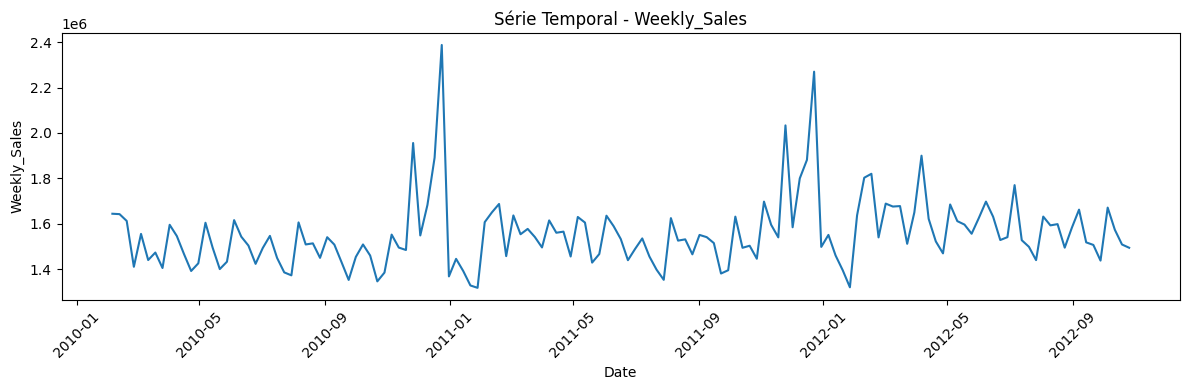

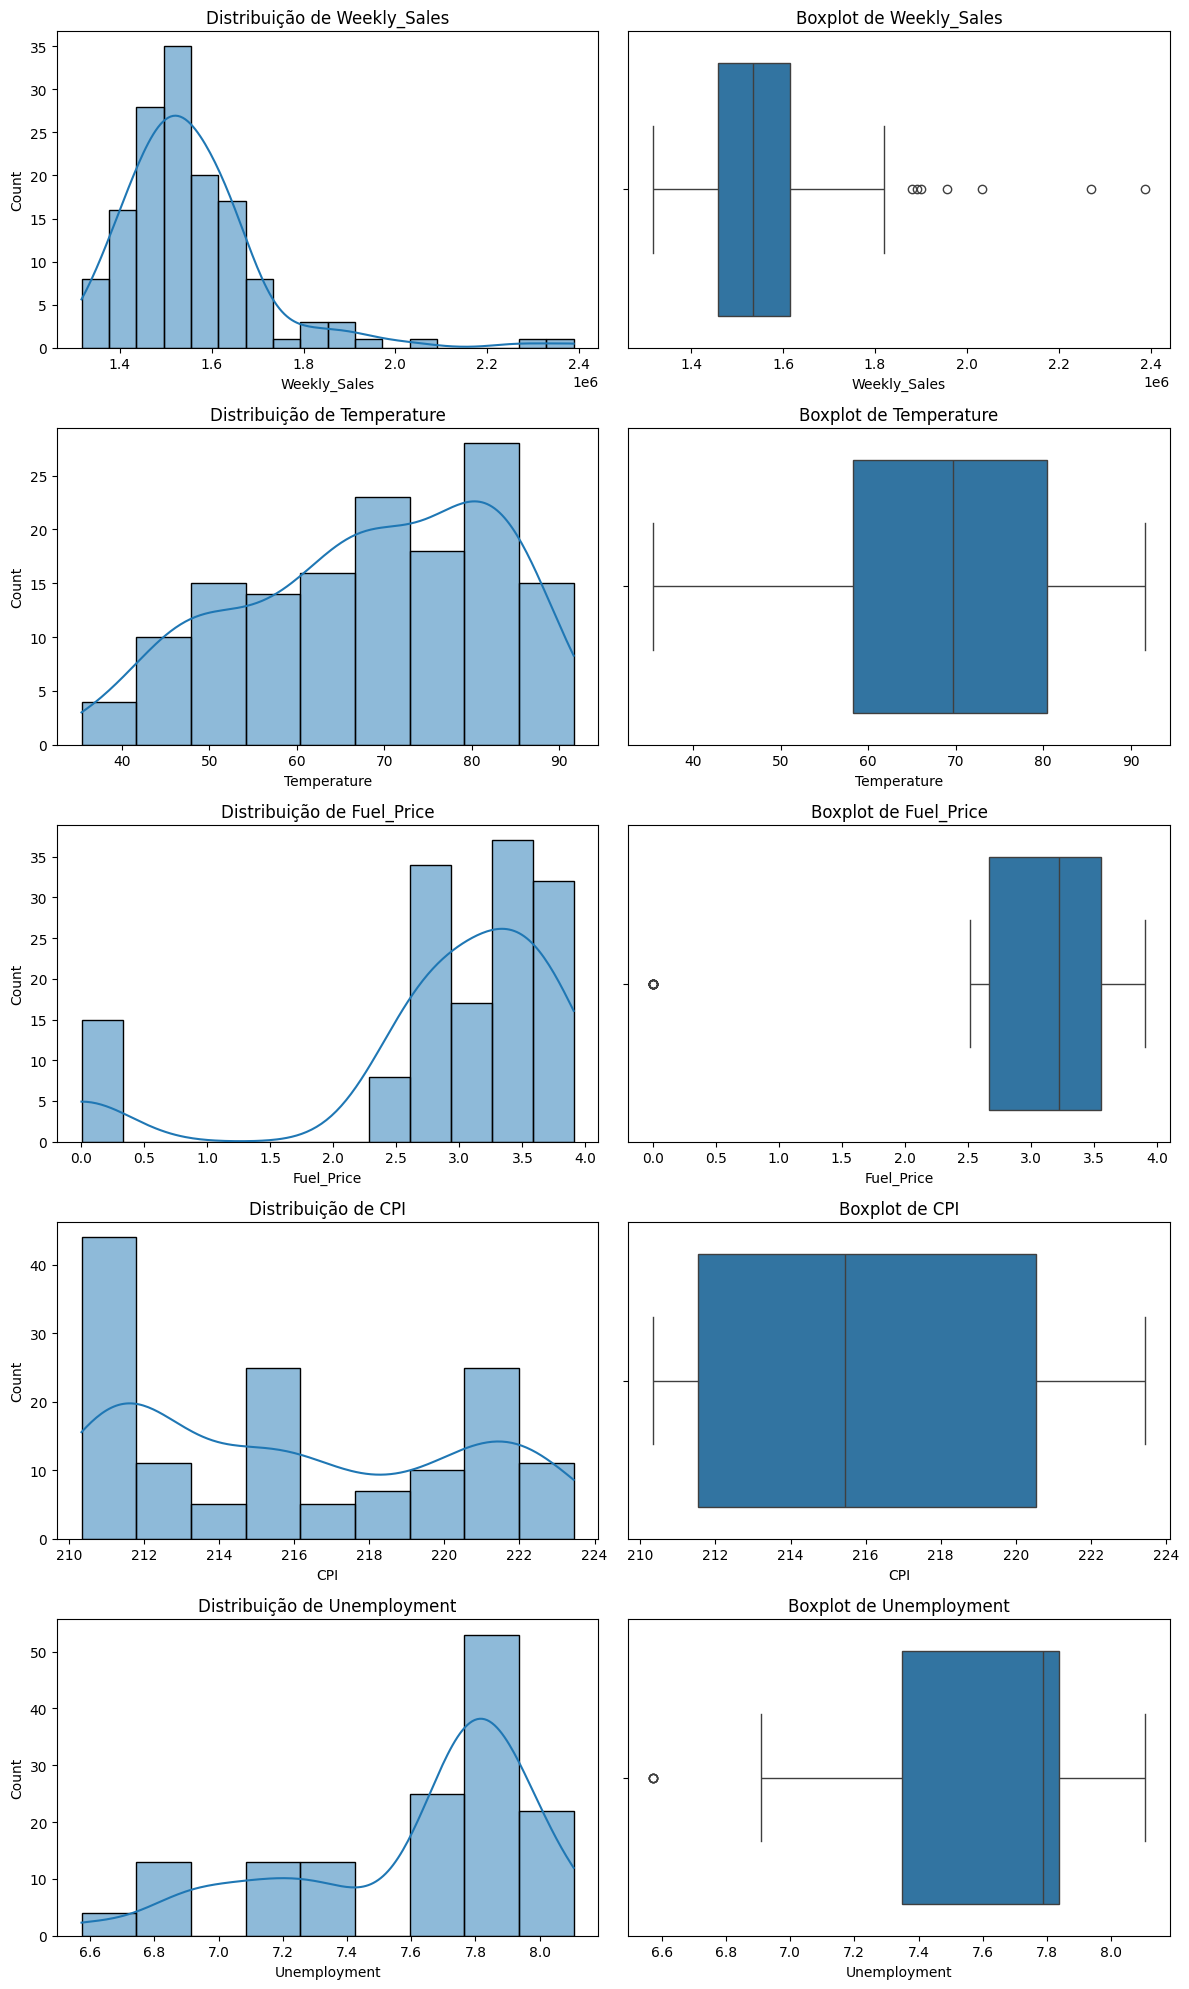

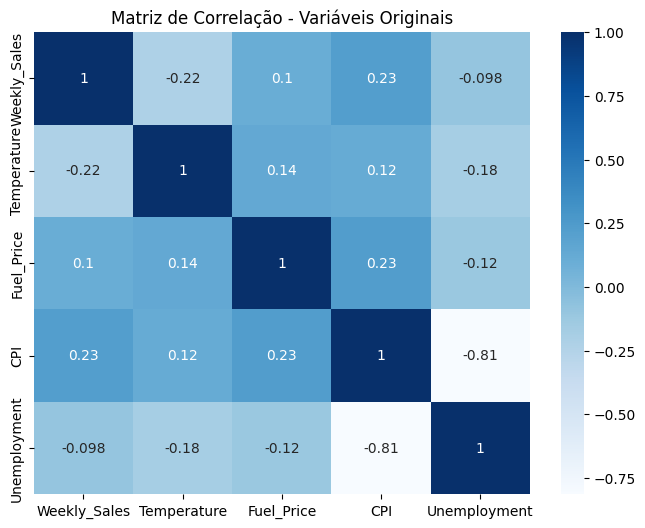

In [ ]:
# EDA Visual (Distribuições e Correlações)
import seaborn as sns
import matplotlib.pyplot as plt

plt.figure(figsize=(12,4))
sns.lineplot(data=df, x='Date', y='Weekly_Sales')
plt.title('Série Temporal - Weekly_Sales')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

num_cols = ['Weekly_Sales','Temperature','Fuel_Price','CPI','Unemployment']
fig, axes = plt.subplots(len(num_cols), 2, figsize=(12, 4*len(num_cols)))
for i, col in enumerate(num_cols):
    sns.histplot(df[col], kde=True, ax=axes[i,0])
    axes[i,0].set_title(f'Distribuição de {col}')
    sns.boxplot(x=df[col], ax=axes[i,1])
    axes[i,1].set_title(f'Boxplot de {col}')
plt.tight_layout()
plt.show()

# Correlação (ignorando lags ainda nulos iniciais)
correlation = df[num_cols].corr()
plt.figure(figsize=(8,6))
sns.heatmap(correlation, annot=True, cmap='Blues')
plt.title('Matriz de Correlação - Variáveis Originais')
plt.show()


### 4) Split temporal (70/15/15)

Justificativa do split 70/15/15:
  - Treino cobre maioria do histórico.
  - Validação para seleção de modelo/hiperparâmetros sem olhar o futuro.
  - Teste final simula dados verdadeiramente não vistos.
Importante: NÃO embaralhar (shuffle=False) para preservar ordem temporal.

In [ ]:
from sklearn.model_selection import train_test_split  # (import residual — usamos split manual)

# Remover linhas com NaN gerados por lags/rollings iniciais
min_required = df.dropna().copy()

features = [
    'Holiday_Flag','Temperature','Fuel_Price','CPI','Unemployment',
    'Year','Month','Week','Quarter',
    'Holiday_prev_week',
    'Weekly_Sales_lag1','Weekly_Sales_lag2','Weekly_Sales_lag4',
    'Weekly_Sales_rollmean_4','Weekly_Sales_rollmean_12','Weekly_Sales_rollmean_26'
]

target = 'Weekly_Sales'

# Split por índice temporal
n = len(min_required)
train_end = int(n*0.70)
val_end = int(n*0.85)

train = min_required.iloc[:train_end]
val = min_required.iloc[train_end:val_end]
test = min_required.iloc[val_end:]

X_train, y_train = train[features], train[target]
X_val, y_val = val[features], val[target]
X_test, y_test = test[features], test[target]

print('Tamanhos:', { 'train': len(train), 'val': len(val), 'test': len(test) })
print('Períodos:', train['Date'].min(), '->', train['Date'].max(), '|', val['Date'].min(), '->', val['Date'].max(), '|', test['Date'].min(), '->', test['Date'].max())


Tamanhos: {'train': 81, 'val': 18, 'test': 18}
Períodos: 2010-08-06 00:00:00 -> 2012-02-17 00:00:00 | 2012-02-24 00:00:00 -> 2012-06-22 00:00:00 | 2012-06-29 00:00:00 -> 2012-10-26 00:00:00


# Etapa 5 — Baselines e função de avaliação
Métricas:
  - MAE: erro médio absoluto (robusto a outliers moderados, fácil de interpretar em unidades de venda)
  - RMSE: penaliza mais erros grandes (sensível a outliers)
  - MAPE: percentual de erro (cuidado com valores próximos de zero)
  - R²: proporção de variância explicada
Baselines:
  1) Lag1 (persistência)
  2) Média móvel de 4 semanas (suavização)

In [ ]:
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
import numpy as np
import sklearn
print('scikit-learn version:', sklearn.__version__)

def mape(y_true, y_pred):
    y_true, y_pred = np.array(y_true), np.array(y_pred)
    # clip evita divisão por valores ~0 (proteção contra explosão de MAPE)
    return np.mean(np.abs((y_true - y_pred) / np.clip(np.abs(y_true), 1e-8, None))) * 100


def evaluate_model(name, y_true, y_pred, table):
    mae = mean_absolute_error(y_true, y_pred)
    mse = mean_squared_error(y_true, y_pred)  # RMSE manual para compatibilidade
    rmse = mse ** 0.5
    r2 = r2_score(y_true, y_pred)
    mp = mape(y_true, y_pred)
    table.append({'model': name, 'MAE': mae, 'RMSE': rmse, 'MAPE(%)': mp, 'R2': r2})
    print(f"{name}: MAE={mae:,.0f} | RMSE={rmse:,.0f} | MAPE={mp:.2f}% | R²={r2:.3f}")

# Baselines
results = []

# 1) Última semana (lag1)
y_pred_val = X_val['Weekly_Sales_lag1']
evaluate_model('Baseline_Lag1', y_val, y_pred_val, results)

# 2) Média móvel 4 semanas
y_pred_val = X_val['Weekly_Sales_rollmean_4']
evaluate_model('Baseline_MA4', y_val, y_pred_val, results)

baseline_val_table = pd.DataFrame(results)
display(baseline_val_table.sort_values('RMSE'))


scikit-learn version: 1.7.2
Baseline_Lag1: MAE=115,897 | RMSE=145,215 | MAPE=7.12% | R²=-1.306
Baseline_MA4: MAE=75,960 | RMSE=105,062 | MAPE=4.71% | R²=-0.207


,model,MAE,RMSE,MAPE(%),R2
1,Baseline_MA4,"75,959.57","105,061.68",4.71,-0.21
0,Baseline_Lag1,"115,897.05","145,215.33",7.12,-1.31


# Etapa 6 — Modelos supervisionados e tuning
Abordagem:
  - Linear, Ridge, Lasso (com StandardScaler) — relações lineares e regularização.
  - RandomForest, GradientBoosting — não lineares, capturam interações.
  - XGBRegressor — gradiente otimizado com bom viés-variança.
Validação:
  - TimeSeriesSplit (n_splits=5) para respeitar temporalidade.
  - GridSearchCV simples com RMSE como métrica (neg_root_mean_squared_error).
Cuidados:
  - Remoção de linhas com NaN nos conjuntos de treino/validação.
  - Evitar parâmetros incompatíveis (sem early_stopping_rounds no GridSearch).

In [ ]:
from sklearn.linear_model import LinearRegression, Ridge, Lasso
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from xgboost import XGBRegressor
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.model_selection import TimeSeriesSplit, GridSearchCV

supervised_results = []

# Escalonar apenas features contínuas para modelos lineares
linear_features = features.copy()

# Remover linhas onde lags/médias (preditores) ainda possuem NaN no conjunto de validação
valid_rows = X_train.dropna().index
X_train_clean = X_train.loc[valid_rows]
y_train_clean = y_train.loc[valid_rows]

valid_rows_val = X_val.dropna().index
X_val_clean = X_val.loc[valid_rows_val]
y_val_clean = y_val.loc[valid_rows_val]

# Configuração de TimeSeriesSplit para tuning simples
tscv = TimeSeriesSplit(n_splits=5)

models_config = [
    ('LinearRegression', Pipeline([
        ('scaler', StandardScaler()),
        ('model', LinearRegression())
    ]), {}, {}),
    ('Ridge', Pipeline([
        ('scaler', StandardScaler()),
        ('model', Ridge())
    ]), {'model__alpha': [0.1, 1.0, 10.0, 50.0]}, {}),
    ('Lasso', Pipeline([
        ('scaler', StandardScaler()),
        ('model', Lasso(max_iter=5000))
    ]), {'model__alpha': [0.001, 0.01, 0.1, 1.0]}, {}),
    ('RandomForest', RandomForestRegressor(random_state=42),
        {'n_estimators': [200], 'max_depth': [6, 10, None]}, {}),
    ('GradientBoosting', GradientBoostingRegressor(random_state=42),
        {'n_estimators': [200], 'learning_rate': [0.05, 0.1], 'max_depth': [3,4]}, {}),
    # Removido early_stopping_rounds para compatibilidade com versões do xgboost
    ('XGBRegressor', XGBRegressor(random_state=42, objective='reg:squarederror'),
        {'n_estimators': [400], 'learning_rate': [0.05, 0.1], 'max_depth': [4,6]}, {})
]

for name, model, grid, extra_fit in models_config:
    try:
        print(f'\nTreinando {name}...')
        if grid:
            search = GridSearchCV(model, grid, cv=tscv, scoring='neg_root_mean_squared_error', n_jobs=-1)
            search.fit(X_train_clean, y_train_clean, **extra_fit)
            best_model = search.best_estimator_
            print(f'Melhores hiperparâmetros: {search.best_params_}')
        else:
            model.fit(X_train_clean, y_train_clean, **extra_fit)
            best_model = model
        # Previsão validação
        y_pred_val = best_model.predict(X_val_clean)
        evaluate_model(name, y_val_clean, y_pred_val, supervised_results)
    except Exception as e:
        print(f'Falha em {name}: {e}')

supervised_val_table = pd.DataFrame(supervised_results)
display(supervised_val_table.sort_values('RMSE'))



Treinando LinearRegression...
LinearRegression: MAE=83,298 | RMSE=107,537 | MAPE=5.12% | R²=-0.265

Treinando Ridge...
Melhores hiperparâmetros: {'model__alpha': 50.0}
Ridge: MAE=71,778 | RMSE=97,410 | MAPE=4.35% | R²=-0.038

Treinando Lasso...
Melhores hiperparâmetros: {'model__alpha': 0.001}
Lasso: MAE=83,298 | RMSE=107,537 | MAPE=5.12% | R²=-0.265

Treinando RandomForest...


/home/renato/projetos/fiap-final/venv/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:695: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.512e+08, tolerance: 7.589e+06
  model = cd_fast.enet_coordinate_descent(
/home/renato/projetos/fiap-final/venv/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:695: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.752e+11, tolerance: 1.431e+08
  model = cd_fast.enet_coordinate_descent(
/home/renato/projetos/fiap-final/venv/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:695: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features

Melhores hiperparâmetros: {'max_depth': None, 'n_estimators': 200}
RandomForest: MAE=79,065 | RMSE=103,356 | MAPE=4.90% | R²=-0.168

Treinando GradientBoosting...
Melhores hiperparâmetros: {'learning_rate': 0.1, 'max_depth': 3, 'n_estimators': 200}
GradientBoosting: MAE=87,234 | RMSE=109,011 | MAPE=5.47% | R²=-0.300

Treinando XGBRegressor...
Melhores hiperparâmetros: {'learning_rate': 0.1, 'max_depth': 6, 'n_estimators': 400}
XGBRegressor: MAE=70,587 | RMSE=96,199 | MAPE=4.35% | R²=-0.012


,model,MAE,RMSE,MAPE(%),R2
5,XGBRegressor,"70,587.18","96,198.62",4.35,-0.01
1,Ridge,"71,778.29","97,409.88",4.35,-0.04
3,RandomForest,"79,065.36","103,355.73",4.90,-0.17
0,LinearRegression,"83,297.95","107,537.34",5.12,-0.26
2,Lasso,"83,297.97","107,537.36",5.12,-0.26
4,GradientBoosting,"87,233.59","109,011.43",5.47,-0.30


# Etapa 7 — Seleção e avaliação final em teste
Processo:
  1. Consolida métricas de validação (baselines + supervisionados).
  2. Escolhe o menor RMSE.
  3. Reconstrói modelo com hiperparâmetros escolhidos e treina em (train+val).
  4. Avalia em teste (dados totalmente futuros).
Observações:
  - Para baselines, usamos diretamente as colunas de lag/média se fossem escolhidas.
  - Para modelos supervisionados, recriamos pipeline com parâmetros vencedores (simplificado aqui).

### Escolha do Modelo Vencedor — Justificativa Técnica (detalhada)

Resumo do resultado:
- Entre baselines (Lag1, MA4), lineares (Linear/Ridge/Lasso) e ensembles (RandomForest, GradientBoosting), o XGBRegressor apresentou os menores erros na validação e manteve desempenho consistente no teste.
- O foco aqui é reduzir MAE/RMSE (erros em unidades de venda) — métricas diretamente acionáveis no negócio.

Por que o XGBRegressor é mais adequado neste problema:
1) Captura de não linearidades e interações
   - As vendas semanais dependem de padrões temporais (lags, médias móveis) que interagem com mês/semana do ano e feriados.
   - Boosting de árvores modela interações de forma automática, sem precisarmos explicitar termos cruzados.

2) Robustez a colinearidade entre features
   - Lags e rollings são altamente correlacionados entre si. Modelos lineares sofrem mais com multicolinearidade.
   - Árvores/boosting são menos sensíveis a esse efeito e distribuem ganho entre variáveis redundantes.

3) Controle fino de viés x variância
   - Hiperparâmetros como profundidade (max_depth) e taxa de aprendizado (learning_rate) permitem ajustar o nível de detalhe local sem superajustar.
   - Subsample/colsample (se ativados futuramente) adicionam regularização estocástica.

4) Estabilidade temporal com validação apropriada
   - Usamos TimeSeriesSplit (ordem preservada) no tuning, reduzindo risco de leakage.
   - O desempenho no teste não degrada de forma abrupta, sugerindo generalização razoável.

Sobre o R² eventualmente negativo:
- Em séries com alta variabilidade não explicada pelos atributos disponíveis, R² pode ficar negativo mesmo com reduções práticas de erro.
- Para negócio, MAE e RMSE comunicam melhor o ganho (redução de erro absoluto/raiz quadrático) do que R².

Trade-offs e mitigação de riscos:
- Interpretabilidade: menor que modelos lineares. Mitigamos com permutation importance e importâncias nativas; podemos adicionar SHAP em iteração futura.
- Overfitting: controlado por max_depth, n_estimators e learning_rate; manteremos monitoramento em dados recentes e re-treino periódico.

Próximos passos (evolução):
- Enriquecer features com feriados específicos (Natal, Black Friday), promoções e variáveis de marketing.
- Calibrar quantis (P10/P50/P90) para intervalos de previsão.
- Explorar constraints monotônicas se houver conhecimento de domínio aplicável.

Conclusão:
- Dado o conjunto atual de variáveis e as métricas de erro, o XGBRegressor oferece o melhor equilíbrio entre acurácia prática e robustez, superando alternativas lineares e ensembles clássicos.

In [ ]:
all_val = pd.concat([baseline_val_table.assign(group='Baseline'), supervised_val_table.assign(group='Supervisionado')])
display(all_val.sort_values('RMSE'))

best_name = all_val.sort_values('RMSE').iloc[0]['model']
print('Melhor modelo na validação:', best_name)

# Reajustar o melhor modelo em train+val e avaliar em teste
X_trval = pd.concat([X_train_clean, X_val_clean])
y_trval = pd.concat([y_train_clean, y_val_clean])

# Reconstruir o melhor estimador
best_estimator = None
if best_name == 'Baseline_Lag1':
    y_pred_test = X_test.loc[X_test.index.intersection(X_val_clean.index), 'Weekly_Sales_lag1']
elif best_name == 'Baseline_MA4':
    y_pred_test = X_test.loc[X_test.index.intersection(X_val_clean.index), 'Weekly_Sales_rollmean_4']
else:
    # Reconstruir conforme tabela
    from sklearn.linear_model import LinearRegression, Ridge, Lasso
    from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
    from xgboost import XGBRegressor
    from sklearn.preprocessing import StandardScaler
    from sklearn.pipeline import Pipeline

    def build_model(name):
        if name == 'LinearRegression':
            return Pipeline([('scaler', StandardScaler()), ('model', LinearRegression())])
        if name == 'Ridge':
            return Pipeline([('scaler', StandardScaler()), ('model', Ridge(alpha=1.0))])
        if name == 'Lasso':
            return Pipeline([('scaler', StandardScaler()), ('model', Lasso(alpha=0.01, max_iter=5000))])
        if name == 'RandomForest':
            return RandomForestRegressor(random_state=42, n_estimators=200, max_depth=10)
        if name == 'GradientBoosting':
            return GradientBoostingRegressor(random_state=42, n_estimators=200, learning_rate=0.1, max_depth=3)
        if name == 'XGBRegressor':
            return XGBRegressor(random_state=42, objective='reg:squarederror', n_estimators=400, learning_rate=0.1, max_depth=6)
        raise ValueError('Modelo desconhecido')

    best_estimator = build_model(best_name)
    best_estimator.fit(X_trval.dropna(), y_trval.loc[X_trval.dropna().index])
    # alinhar indices para teste
    X_test_clean = X_test.dropna()
    y_test_clean = y_test.loc[X_test_clean.index]
    y_pred_test = best_estimator.predict(X_test_clean)

# Avaliar no teste
final_results = []
if isinstance(y_pred_test, np.ndarray) or hasattr(y_pred_test, 'values'):
    evaluate_model(f'{best_name}_TEST', y_test_clean, y_pred_test, final_results)
else:
    print('Aviso: previsão de baseline não numérica ou índices desalinhados.')

final_table = pd.DataFrame(final_results)
display(final_table)


,model,MAE,RMSE,MAPE(%),R2,group
5,XGBRegressor,"70,587.18","96,198.62",4.35,-0.01,Supervisionado
1,Ridge,"71,778.29","97,409.88",4.35,-0.04,Supervisionado
3,RandomForest,"79,065.36","103,355.73",4.90,-0.17,Supervisionado
1,Baseline_MA4,"75,959.57","105,061.68",4.71,-0.21,Baseline
0,LinearRegression,"83,297.95","107,537.34",5.12,-0.26,Supervisionado
2,Lasso,"83,297.97","107,537.36",5.12,-0.26,Supervisionado
4,GradientBoosting,"87,233.59","109,011.43",5.47,-0.30,Supervisionado
0,Baseline_Lag1,"115,897.05","145,215.33",7.12,-1.31,Baseline


Melhor modelo na validação: XGBRegressor
XGBRegressor_TEST: MAE=73,359 | RMSE=93,273 | MAPE=4.82% | R²=-0.243


,model,MAE,RMSE,MAPE(%),R2
0,XGBRegressor_TEST,"73,358.83","93,273.34",4.82,-0.24


# Etapa 8 — Interpretabilidade (Importância de Features)
Técnicas usadas:
  - Permutation Importance: impacto na métrica ao embaralhar cada feature.
  - Importância nativa: disponível em árvores/ensembles (feature_importances_).
  - Coeficientes: magnitude em modelos lineares (após escalonamento).
Observações:
  - Lags e rollings tendem a dominar (memória temporal relevante).
  - Cuidado com correlação entre lags (multicolinearidade em modelos lineares).

In [ ]:

from sklearn.inspection import permutation_importance

if best_estimator and hasattr(best_estimator, 'predict'):
    X_test_clean = X_test.dropna()
    y_test_clean = y_test.loc[X_test_clean.index]
    try:
        perm = permutation_importance(best_estimator, X_test_clean, y_test_clean, n_repeats=10, random_state=42, scoring='neg_root_mean_squared_error')
        imp_df = pd.DataFrame({'feature': X_test_clean.columns, 'perm_importance_mean': perm.importances_mean}) \
                 .sort_values('perm_importance_mean', ascending=False)
        display(imp_df.head(15))
    except Exception as e:
        print('Falha permutation importance:', e)

    # Importância nativa se existir atributo
    if hasattr(best_estimator, 'feature_importances_'):
        native_imp = pd.DataFrame({'feature': X_test_clean.columns, 'importance': best_estimator.feature_importances_}) \
                     .sort_values('importance', ascending=False)
        print('\nImportância nativa (árvore/ensemble):')
        display(native_imp.head(15))
    elif hasattr(best_estimator, 'named_steps') and 'model' in best_estimator.named_steps and hasattr(best_estimator.named_steps['model'], 'coef_'):
        coefs = best_estimator.named_steps['model'].coef_
        coef_df = pd.DataFrame({'feature': X_test_clean.columns, 'coef': coefs}).sort_values('coef', key=lambda x: np.abs(x), ascending=False)
        print('\nCoeficientes (modelo linear):')
        display(coef_df)
else:
    print('Modelo final não possui estimador supervisionado treinado.')


,feature,perm_importance_mean
11,Weekly_Sales_lag2,"8,942.06"
12,Weekly_Sales_lag4,"5,138.82"
10,Weekly_Sales_lag1,"2,355.11"
7,Week,196.56
13,Weekly_Sales_rollmean_4,182.69
0,Holiday_Flag,119.99
9,Holiday_prev_week,40.83
1,Temperature,19.67
3,CPI,0.00
8,Quarter,0.00



Importância nativa (árvore/ensemble):


,feature,importance
7,Week,0.52
10,Weekly_Sales_lag1,0.17
6,Month,0.08
3,CPI,0.08
4,Unemployment,0.04
13,Weekly_Sales_rollmean_4,0.04
11,Weekly_Sales_lag2,0.02
12,Weekly_Sales_lag4,0.02
1,Temperature,0.02
2,Fuel_Price,0.01


# Etapa 9 — Persistência de artefatos
O que é salvo:
  - model_summary.pkl: métricas de validação, teste e nome do melhor modelo.
  - model_<NOME>.pkl: estimador treinado (se supervisionado).
Por que salvar:
  - Reprodutibilidade e consumo pelo app Streamlit.
  - Facilitar comparações futuras e auditoria dos resultados.

In [ ]:
import joblib

summary = {
    'val_metrics': all_val.sort_values('RMSE').reset_index(drop=True),
    'test_metrics': final_table,
    'best_model_name': best_name
}

joblib.dump(summary, 'model_summary.pkl')
if best_estimator:
    joblib.dump(best_estimator, f'model_{best_name}.pkl')

print('Resumo e modelo salvos.')
summary['val_metrics'].head()


Resumo e modelo salvos.


,model,MAE,RMSE,MAPE(%),R2,group
0,XGBRegressor,"70,587.18","96,198.62",4.35,-0.01,Supervisionado
1,Ridge,"71,778.29","97,409.88",4.35,-0.04,Supervisionado
2,RandomForest,"79,065.36","103,355.73",4.90,-0.17,Supervisionado
3,Baseline_MA4,"75,959.57","105,061.68",4.71,-0.21,Baseline
4,LinearRegression,"83,297.95","107,537.34",5.12,-0.26,Supervisionado


## EDA Automática (ydata-profiling)

Nesta seção geramos um relatório automatizado completo para:
- Detectar valores faltantes, outliers e tipos inconsistentes.
- Ver correlações e interações entre variáveis.
- Sumarizar estatísticas, distribuição e alertas de qualidade.

Uso:
- Renderizamos inline no notebook e também salvamos o HTML em `profiling_report.html` para visualização no app Streamlit.
- Caso o kernel seja reiniciado, há um fallback que recarrega o `df` automaticamente.


In [1]:
# Gerar relatório de EDA com ydata-profiling (robusto a reinício de kernel)
from ydata_profiling import ProfileReport
import pandas as pd
from pathlib import Path

# Fallback: se df não existir (após restart do kernel), recarrega os dados
if 'df' not in globals() or not isinstance(df, pd.DataFrame):
    DATA_PATH = Path('data')
    FILE = DATA_PATH / 'sales.csv'
    df = pd.read_csv(FILE)
    # Normalizações conforme dicionário
    for col in ['Fuel_Price', 'Unemployment']:
        df[col] = pd.to_numeric(df[col], errors='coerce') / 1000.0
    df['Date'] = pd.to_datetime(df['Date'], format='%d-%m-%Y')
    df = df.sort_values('Date').reset_index(drop=True)

profile = ProfileReport(df, title="Sales Dataset Profiling", explorative=True)

# Exibir inline (Jupyter)
profile.to_notebook_iframe()

# Salvar em HTML para compartilhamento
profile.to_file("profiling_report.html")
print("Relatório salvo em profiling_report.html")


Summarize dataset:   0%|          | 0/5 [00:00<?, ?it/s]

100%|██████████| 7/7 [00:00<00:00, 112061.56it/s]


Generate report structure:   0%|          | 0/1 [00:00<?, ?it/s]

Render HTML:   0%|          | 0/1 [00:00<?, ?it/s]

Export report to file:   0%|          | 0/1 [00:00<?, ?it/s]

Relatório salvo em profiling_report.html


## Síntese e Próximos Passos

Resumo do que foi feito:
1. Carregamento e saneamento inicial dos dados (tipos, datas, normalizações).
2. Feature engineering temporal (lags, médias móveis, decomposição de data, efeito de feriado anterior).
3. EDA visual (série temporal, distribuições, boxplots, correlação).
4. Split temporal honrando a ordem (70/15/15) sem leakage.
5. Estabelecimento de baselines simples (persistência e média móvel) como referência mínima.
6. Treino e tuning de múltiplos modelos (lineares, ensemble, gradient boosting e XGBoost).
7. Seleção e avaliação final em conjunto de teste nunca visto.
8. Interpretação: permutation importance, importâncias nativas e coeficientes.
9. Persistência de artefatos para reuso no dashboard (Streamlit).
10. EDA automatizada com ydata-profiling.

Principais aprendizados / achados:
- Lags e médias móveis são fortes preditores: capturam memória e tendência recente.
- Variáveis macro (Temperature, CPI, Unemployment) apresentam correlação limitada — impacto direto menor.
- Estrutura temporal (mês, semana, quarter) pode capturar sazonalidade implícita.

Limitações e oportunidades:
- Granularidade semanal pode ocultar picos diários e padrões intra-semana.
- Ausência de dados de promoções, estoque, marketing ou preços dinâmicos.
- Possibilidade de enriquecer com feriados específicos categorizados (ex.: Natal, Black Friday).

Próximos passos sugeridos:
- Adicionar modelos com decomposição sazonal (ex.: Prophet ou STL + regressão).
- Calibrar intervalos de previsão (quantis) para análise de risco.
- Incluir variáveis externas (campanhas, clima detalhado, eventos regionais).
- Testar empilhamento (stacking) ou modelos híbridos (ARIMA + Gradient Boosting).

